In [2]:
import sys
sys.path.insert(0, '../src/')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy.sparse as sp
from scipy.sparse import load_npz
import pickle

import torch

import utils
from net import start_experiments
import graph_statistics
from evaluation import (Evaluation, tabular_from_statistics, df_from_tabular, compute_original_statistics,
                        boxplot)

In [8]:
train_graph, _ = pickle.load(open('../data/datasets/cycle.p', 'rb'))
train_graph = sp.csr_matrix(train_graph)

In [15]:
import matplotlib.pyplot as plt
def plot_graph(A, Xs):
    Is, Js = A.nonzero()
    nonzero_indices = np.array((Is, Js)).T
    
    f, axs = plt.subplots(figsize=(12,12))

    for l in range(nonzero_indices.shape[0]):
        style = 'ko-'
        axs.plot(Xs[nonzero_indices[l], 0], Xs[nonzero_indices[l], 1], style)
    plt.show()
    return

In [18]:
models = start_experiments(num_experiments=5,
                           experiment_root='../logs/cycle/Ours',
                           train_graph=train_graph,
                           H=5,
                           optimizer=torch.optim.Adam,
                           optimizer_args={'lr': 0.1,
                                           'weight_decay': 1e-7},
                           invoke_every=5,
                           steps = 100,
                           val_edges=(None, None))


Experiment_0
Step:   5/100, Loss: 5.37763, Edge-Overlap: 0.040
Step:  10/100, Loss: 4.29092, Edge-Overlap: 0.162
Step:  15/100, Loss: 3.47571, Edge-Overlap: 0.362
Step:  20/100, Loss: 3.02790, Edge-Overlap: 0.527
Step:  25/100, Loss: 2.79986, Edge-Overlap: 0.640
Step:  30/100, Loss: 2.66195, Edge-Overlap: 0.688
Step:  35/100, Loss: 2.55911, Edge-Overlap: 0.743
Step:  40/100, Loss: 2.47829, Edge-Overlap: 0.761
Step:  45/100, Loss: 2.41430, Edge-Overlap: 0.781
Step:  50/100, Loss: 2.36346, Edge-Overlap: 0.802
Step:  55/100, Loss: 2.32542, Edge-Overlap: 0.833
Step:  60/100, Loss: 2.29933, Edge-Overlap: 0.841
Step:  65/100, Loss: 2.27933, Edge-Overlap: 0.851
Step:  70/100, Loss: 2.26326, Edge-Overlap: 0.858
Step:  75/100, Loss: 2.25028, Edge-Overlap: 0.876
Step:  80/100, Loss: 2.24023, Edge-Overlap: 0.891
Step:  85/100, Loss: 2.23181, Edge-Overlap: 0.890
Step:  90/100, Loss: 2.22469, Edge-Overlap: 0.881
Step:  95/100, Loss: 2.21848, Edge-Overlap: 0.902
Step: 100/100, Loss: 2.21311, Edge-O

In [ ]:
statistic_fns = {#'Assortativity':graph_statistics.assortativity,
                 #'Average Degree':graph_statistics.average_degree,
                 'Claw Count':graph_statistics.claw_count,
                 #'Clustering Coefficient':graph_statistics.clustering_coefficient,
                 #'Characteristic Path Length':graph_statistics.compute_cpl,
                 #'Edge Distribution Entropy':graph_statistics.edge_distribution_entropy,
                 #'Gini':graph_statistics.gini,
                 #'LCC Size':graph_statistics.LCC,
                 #'Max Degree':graph_statistics.max_degree,
                 #'Min Degree':graph_statistics.min_degree,
                 #'Num Connected Components':graph_statistics.num_connected_components,
                 #'Power Law α':graph_statistics.power_law_alpha,
                 #'Spectral Gap':graph_statistics.spectral_gap,
                 'Square Count':graph_statistics.square_count,
                 #'Triangle Count':graph_statistics.triangle_count,
                 'Wedge Count':graph_statistics.wedge_count,
                 }

eval_cycle = Evaluation(experiment_root='../logs/cycle/Ours',
                       statistic_fns=statistic_fns)

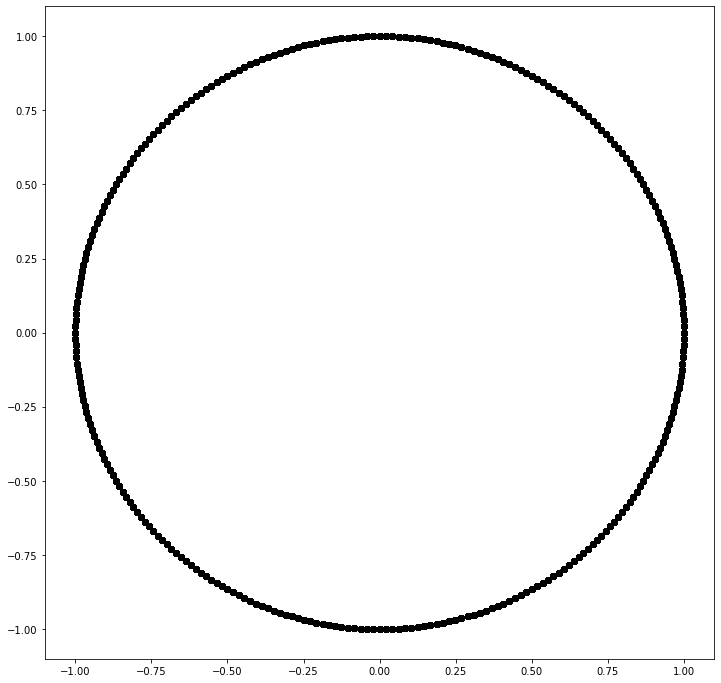

In [16]:
plot_graph(train_graph, _)

## Define new loss function that punishes long non-edges

In [77]:
def get_my_loss_fn(SP, lam):
    def my_loss_fn(W, A, num_edges):
        d = torch.log(torch.exp(W).sum(dim=-1, keepdims=True))
        loss = torch.sum((lam * (1-A) * SP - A) * (W - d * torch.ones_like(A)))
        loss *= .5 / num_edges
        return loss
    return my_loss_fn

In [62]:
import networkx as nx
G = nx.from_scipy_sparse_matrix(train_graph)
B = nx.all_pairs_shortest_path_length(G)

B_dict = dict(B)

SP = np.zeros(train_graph.shape)

for start in B_dict.keys():
    for target in B_dict[start].keys():
        SP[start, target] = B_dict[start][target]

In [78]:
my_loss_fn = get_my_loss_fn(SP=SP, lam=0.1)